In [596]:
# import libraries 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime

## Missing Data

In [597]:
# import files
missing_data = pd.read_csv('35087056_missing_data.csv')
warehouses = pd.read_csv('warehouses.csv')

In [598]:
missing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              445 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    485 non-null    float64
 6   delivery_charges               460 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   coupon_discount                500 non-null    int64  
 10  order_total                    485 non-null    float64
 11  season                         500 non-null    object 
 12  is_expedited_delivery          500 non-null    boo

In [599]:
warehouses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   names   3 non-null      object 
 1   lat     3 non-null      float64
 2   lon     3 non-null      float64
dtypes: float64(2), object(1)
memory usage: 204.0+ bytes


### Missing Data - EDA

In [600]:
# Find fields containing 
missing_data_eda = missing_data.isna().sum()[missing_data.isna().sum() > 0].to_frame()

# Reset Index, Rename columns and display table
missing_data_eda = missing_data_eda.reset_index()
missing_data_eda = missing_data_eda.rename(columns={'index':'Column',0:'Missing Row Count'})
missing_data_eda


,Column,Missing Row Count
0,nearest_warehouse,55
1,order_price,15
2,delivery_charges,40
3,order_total,15
4,distance_to_nearest_warehouse,31
5,is_happy_customer,40


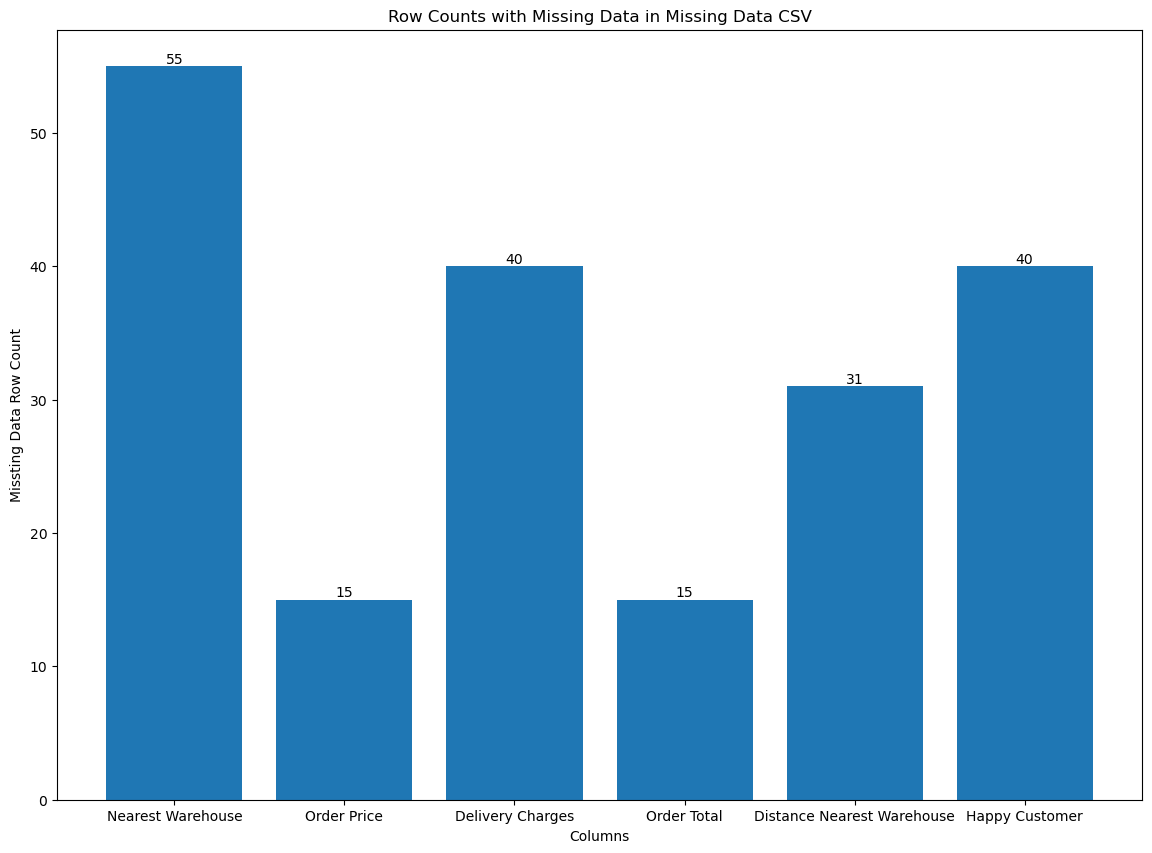

In [601]:
# Visualise

nearest_warehouse_missing = missing_data['nearest_warehouse'].isna().sum()
order_prince_missing = missing_data['order_price'].isna().sum()
delivery_charges_missing = missing_data['delivery_charges'].isna().sum()
order_total_missing = missing_data['order_total'].isna().sum()
distance_warehouse_missing = missing_data['distance_to_nearest_warehouse'].isna().sum()
is_happy_customer_missing = missing_data['is_happy_customer'].isna().sum()

missing_data_counts = [nearest_warehouse_missing,order_prince_missing,delivery_charges_missing,
                       order_total_missing,distance_warehouse_missing,is_happy_customer_missing]
variables = ['Nearest Warehouse', 'Order Price', 'Delivery Charges', 'Order Total', 'Distance Nearest Warehouse','Happy Customer']

fig, ax = plt.subplots(figsize=(14, 10))
bars = plt.bar(variables, missing_data_counts)

for bar in bars:
    height = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Columns')
plt.ylabel('Missting Data Row Count')
plt.title('Row Counts with Missing Data in Missing Data CSV')
plt.show()

In [602]:
# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    alpha = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    distance = R * 2 * np.arctan2(np.sqrt(alpha), np.sqrt(1 - alpha))
    return distance

In [603]:
# Nearest Warehouse 
missing_data['nearest_warehouse'] = missing_data.apply(
    lambda row: warehouses.loc[
        warehouses.apply(
            lambda x: haversine(row['customer_lat'], row['customer_long'], x['lat'], x['lon']),
            axis=1
        ).idxmin()]['names'] if pd.isnull(row['nearest_warehouse']) else row['nearest_warehouse'],
    axis=1
)

In [604]:
# Distance to Nearest Warehouse
merged_df = pd.merge(missing_data, warehouses, how='left', left_on='nearest_warehouse', right_on='names')

for idx, row in merged_df.iterrows():
    if pd.isnull(row['distance_to_nearest_warehouse']):
        merged_df.at[idx,'distance_to_nearest_warehouse'] = round(haversine(row['customer_lat'], 
                                                                            row['customer_long'], row['lat'], row['lon']),4)

missing_data = merged_df.drop(columns=['names','lat','lon'])

In [605]:
# Order Price
from sklearn.impute import KNNImputer

# Select relevant columns for imputation
columns_to_use = ['shopping_cart', 'order_price', 'delivery_charges',
                  'coupon_discount', 'distance_to_nearest_warehouse', 'order_total']

data_subset = missing_data[columns_to_use].copy()

# Get count of itmes containing within shopping card for each row
data_subset['shopping_cart_items'] = data_subset['shopping_cart'].apply(
    lambda x: sum(int(item.split(",")[1].strip().strip(')')) for item in x.strip('[]').split('), (')) if isinstance(x, str) else 0
)

# Drop the original shopping_cart column and rearrange
data_subset = data_subset.drop(columns=['shopping_cart'])

# Separate fields to impute (order_total)
fields_to_impute = 'order_price'

# Convert to numeric and check for nulls
data_subset[fields_to_impute] = pd.to_numeric(data_subset[fields_to_impute], errors='coerce')

# Use KNN Imputer
imputer = KNNImputer(n_neighbors=1)
imputed_data = imputer.fit_transform(data_subset)

# Convert the result back to a DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=data_subset.columns)

# Restore the imputed 'order_total' to the original DataFrame
missing_data['order_price'] = imputed_df['order_price']

In [606]:
# Order Total
missing_data['order_total'] = missing_data.apply(
    lambda row: row['order_price'] * (1 - (row['coupon_discount']/100)) if pd.isna(row['order_total']) else row['order_total'],
    axis=1
)

In [607]:
# Delivery Charges
missing_data['delivery_charges'] = missing_data.apply(
    lambda row: row['order_price'] - row['order_total']  if pd.isna(row['delivery_charges']) else row['delivery_charges'],
    axis=1
)

In [608]:
# Happy Customer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

missing_data['is_happy_customer'] = missing_data.apply(
    lambda row: 1 if pd.isnull(row['is_happy_customer']) and vader.polarity_scores(row['latest_customer_review'])['compound'] > 0 
    else (0 if pd.isnull(row['is_happy_customer']) else row['is_happy_customer']),
    axis=1
)

In [609]:
# Write missing data solution to csv
missing_data.to_csv('35087056_missing_data_solution.csv')

## Dirty Data

In [610]:
dirty_data = pd.read_csv('35087056_dirty_data.csv')

In [611]:
dirty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              500 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    500 non-null    int64  
 6   delivery_charges               500 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   coupon_discount                500 non-null    int64  
 10  order_total                    500 non-null    float64
 11  season                         500 non-null    object 
 12  is_expedited_delivery          500 non-null    boo

In [612]:
dirty_data['customer_lat'] = dirty_data['customer_lat'].astype(str)
dirty_data['customer_long'] = dirty_data['customer_long'].astype(str)

In [613]:
# Dirty Data - EDA

dirty_date_count = dirty_data['date'].str.contains('-').sum()
warehouse_names = dirty_data['nearest_warehouse'].str.islower().sum()
lat_decimals = dirty_data['customer_lat'].apply(lambda x: 1 if isinstance(x, str) and "." in x and len(x.split(".")[1]) != 7 else 0).sum()
lon_decimals = dirty_data['customer_long'].apply(lambda x: 1 if isinstance(x, str) and "." in x and len(x.split(".")[1]) != 7 else 0).sum()
affected_review_count = sum(dirty_data['latest_customer_review'].apply(lambda x: ''.join([char for char in str(x) 
                                                                                          if (32 <= ord(char) <= 126 or char == '!')])) != dirty_data['latest_customer_review'])

dirty_data_eda = {'Incorrect_Date':dirty_date_count,
                 'Incorrect_Warehouse_Names':warehouse_names,
                 'Adjust_Lat_Decimals':lat_decimals,
                 'Adjust_Lon_Decimals':lon_decimals,
                 'Non_ASCII_Rows_Review':affected_review_count}

# Reset Index, Rename columns and display table
dirty_data_eda = pd.DataFrame.from_dict(dirty_data_eda,orient='index')
dirty_data_eda = dirty_data_eda.reset_index()
dirty_data_eda = dirty_data_eda.rename(columns={'index':'Column',0:'Error Row Count'})
dirty_data_eda

,Column,Error Row Count
0,Incorrect_Date,14
1,Incorrect_Warehouse_Names,22
2,Adjust_Lat_Decimals,60
3,Adjust_Lon_Decimals,52
4,Non_ASCII_Rows_Review,28


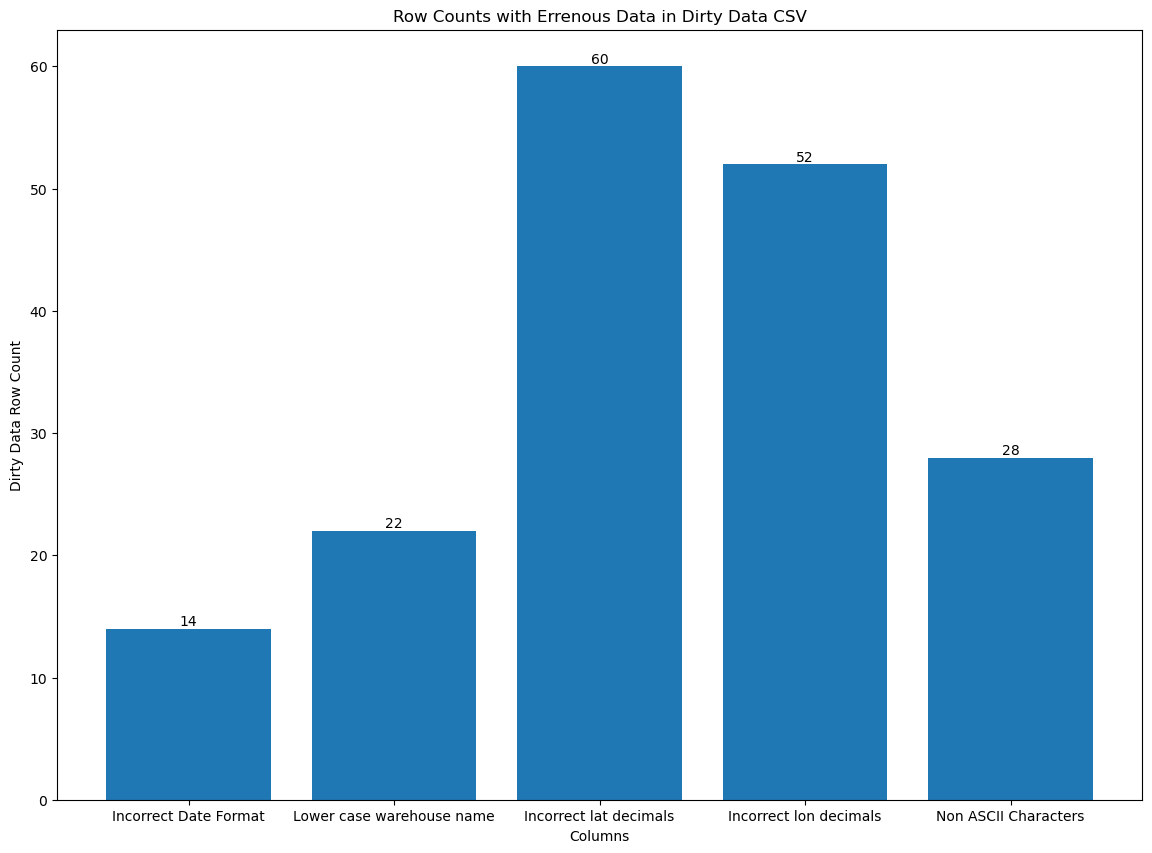

In [614]:
# Dirty Data - Visual EDA

dirty_data_counts = [dirty_date_count,warehouse_names,lat_decimals,lon_decimals,affected_review_count]
variables = ['Incorrect Date Format', 'Lower case warehouse name', 'Incorrect lat decimals', 'Incorrect lon decimals', 'Non ASCII Characters']

fig, ax = plt.subplots(figsize=(14, 10))
bars = plt.bar(variables, dirty_data_counts)

for bar in bars:
    height = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Columns')
plt.ylabel('Dirty Data Row Count')
plt.title('Row Counts with Errenous Data in Dirty Data CSV')
plt.show()

In [615]:
# Date 
dirty_data['date'] = missing_data.apply(
    lambda row: datetime.strptime(row['date'], '%Y-%m-%d') if '-' in str(row['date']) else row['date'],
    axis=1
)

In [616]:
# Nearest Warehouse Names Title case
dirty_data['nearest_warehouse'] = missing_data.apply(
    lambda row: row['nearest_warehouse'].title() if row['nearest_warehouse'].islower() else row['nearest_warehouse'],
    axis=1
)

In [617]:
# Customer_lat and Customer_long adjustment
dirty_data['customer_lat'] = dirty_data['customer_lat'].astype(float)
dirty_data['customer_long'] = dirty_data['customer_long'].astype(float)

dirty_data['customer_lat'] = dirty_data['customer_lat'].apply(lambda x: round(x, 7))
dirty_data['customer_long'] = dirty_data['customer_long'].apply(lambda x: round(x, 7))

In [618]:
# Distance to Nearest Warehouse
dirty_data['distance_to_nearest_warehouse'] = dirty_data['distance_to_nearest_warehouse'].apply(lambda x: round(x, 4))

In [619]:
# Customer reviews
dirty_data['latest_customer_review'] = dirty_data['latest_customer_review'].apply(
    lambda x: ''.join([char for char in str(x) if (32 <= ord(char) <= 126 or char == '!')])
)

In [620]:
dirty_data.to_csv('35087056_dirty_data_solution.csv')

## Outlier Data

In [621]:
# Read in outlier csv
outlier_data = pd.read_csv('35087056_outlier_data.csv')

In [622]:
# Define quartile 1 and 3

q1 = outlier_data['delivery_charges'].quantile(0.25)
q3 = outlier_data['delivery_charges'].quantile(0.75)

# Calculate interquartile range
iqr = q3 - q1

# Set outlier threshold
threshold = 1.5



In [623]:
# EDA

outlier_count = len(outlier_data[((outlier_data['delivery_charges'] < q1 - threshold * iqr) | (outlier_data['delivery_charges'] > q3 + threshold * iqr))])

print(f'There are {outlier_count} outlier delivery charges outlier rows in a data set containing {len(outlier_data)} rows')

There are 18 outlier delivery charges outlier rows in a data set containing 500 rows


In [624]:
# Filter data frame on delivery charges values that are not outliers
#outlier_data = outlier_data[~((outlier_data['delivery_charges'] < q1 - threshold * iqr) | (outlier_data['delivery_charges'] > q3 + threshold * iqr))]

In [625]:
# Create outlier solution csv
#utlier_data.to_csv('35087056_outlier_data_solution.csv')

## Delivery Charges Validation with Linear Regression - Missing Data Solution CSV

In [626]:
missing_data_clean = pd.read_csv('35087056_missing_data_solution.csv')

In [627]:
missing_data_clean['is_expedited_delivery'] = missing_data_clean.apply(lambda row: 1 if row['is_expedited_delivery'] == True else 0, axis=1)

missing_data_clean["is_expedited_delivery"] = missing_data_clean["is_expedited_delivery"].astype(int)

In [628]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

# Load the dataset
data = missing_data_clean

# Features and target
features = ["distance_to_nearest_warehouse", "is_expedited_delivery",
            "is_happy_customer", "order_total", "season"]

target = "delivery_charges"

# Outlier Detection
q1 = outlier_data['delivery_charges'].quantile(0.25)
q3 = outlier_data['delivery_charges'].quantile(0.75)

IQR = q3 - q1
lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

# Filter outliers
filtered_data = data[(data["delivery_charges"] >= lower_bound) & (data["delivery_charges"] <= upper_bound)]

# Separate features and target
X_filtered = filtered_data[features]
y_filtered = filtered_data[target]

# Preprocessing: One-hot encode 'season', scale numerical features, and vectorize 'latest_customer_review'
preprocessor = ColumnTransformer(
    transformers=[
        ("season", OneHotEncoder(), ["season"]),
        ("scaler", StandardScaler(), ["distance_to_nearest_warehouse", "is_expedited_delivery", 
                                       "is_happy_customer", "order_total"])
    ]
)

# Build the pipeline
pipeline = make_pipeline(
    preprocessor,
    LinearRegression()
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.4, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Linear Regression R^2 Score: {round(r2,2)}")

Linear Regression R^2 Score: 0.96


## References